# Dominant colours - Introduction
This is the second part of my [dezeenAI](https://github.com/adamsiemaszkiewicz/dezeenAI) project meant to build an object and colour detection search engine based on the [Dezeen.com](http://dezeen.com/)'s Interior category.

This notebook builds a dominant colours detection system based on K-Means clustering algorithm to find a list of 10 dominant colours and their distribution for each picture in the dataset.

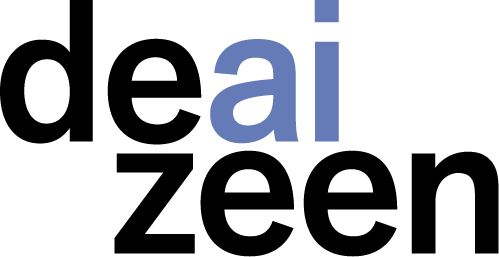

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/dezeenAI': File exists
/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Libraries & functions
- `requests` - http handling
- `BeautifulSoup` - html parsing & web-scraping
- `urllib.request` - url-opening
- `tqdm` - loop progress bar
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `sys` - system-specific parameters & functions
- `os.path` - common pathname manipulations

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import timeit
import tqdm.notebook as tq
import sys
import os.path

# Colour detection
Let's build a colour detection system to find a palette of dominant colours for each picture in the dataset. The system will use [OpenCV](https://opencv.org/) library, as well as K-Means clustering class from [scikit-learn](https://scikit-learn.org/)

1. Import the images DataFrame
2. Set up helper functions:
  - `displayImage()` to display image files inside the notebook
  - `preprocessImage()` to prepare the image files for clustering
  - `clusterColors()` to find color cluster of the image
  - `centroidHistogram()` to find the distribution of the colors
  - `colorBar()` to display the color palette
3. Test the system on a random picture
4. Scan all pictures to find their dominant colors and their distribution
5. Create and export the DataFrame with the results

## Images DataFrame
Let's import the images DataFrame we created in the last notebook and flip its order in order to keep chronological order of the data.

In [4]:
# import the DataFrame
df = pd.read_csv('files/df_articles-images-downloaded.csv', index_col=0)

# reverse the order and reset index
df = df[::-1]
df.reset_index(drop=True, inplace=True)
df

,id,url,path
0,15,http://static.dezeen.com/uploads/2006/11/k.jpg,/mydrive/data/dezeen/15/k.jpg
1,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg
2,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg
3,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg
4,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg
...,...,...,...
47224,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...
47225,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...
47226,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...
47227,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...


## Functions
Let's define some functions we're gonna use throughout the notebook:

- `displayImage()` displays the image provided
- `processImage()` prepares the image for color clustering
- `clusterColors()` finds the color cluster in the image
- `centroidHistogram()` finds the distribution of the color clusters
- `colorBar()` graphically represents dominant colors and their distribution

In [5]:
def displayImage(image):

  '''
  Takes the image path and displays it in the notebook.

  Parameters:
  path (str or ndarray): A path to the image file or an ndarray image

  Returns:
  Nothing
  '''
  
  if isinstance(image, str):
  
    # read image file (stored in BGR order)
    image = cv2.imread(image)
    # convert image to RGB color model
    image = cv2.cvtColor(
        image,
        cv2.COLOR_BGR2RGB
        )

  # switch off axis
  plt.axis('off')

  # display image
  plt.imshow(image)

In [6]:
def preprocessImage(path, dsize=(16,16)):

  '''
  Takes the image path and the output size to scale down the image.

  Parameters:
  path (str): Path to the image file
  dsize (tuple of int): Dimensions of the scaled down version of the image (default: (16,16))

  Returns:
  image (ndarray): Scaled down image as a ndarray.
  '''

  # read image file (stored in BGR order)
  image = cv2.imread(path)
  # convert image to RGB color model
  image = cv2.cvtColor(
      image,
      cv2.COLOR_BGR2RGB
      )

  # scale down the image
  image = cv2.resize(
      image,
      dsize=dsize,
      interpolation=cv2.INTER_CUBIC
      )

  return image

In [7]:
def clusterColors(image, clusters=10):

  '''
  Takes the preprocessed image ndarray and finds its color clusters using K-Means clustering.

  Parameters:
  image (ndarray): Preprocessed image
  clusters (int): Number of clusters to find

  Returns:
  clt (estimator): Fitted KMeans estimator
  '''

  # reshape the image to a list of pixels (width * height, depth)
  image = image.reshape((image.shape[0] * image.shape[1],3))

  # cluster the color in the image
  clt = KMeans(n_clusters=clusters)
  clt.fit(image)

  return clt

In [8]:
def centroidHistogram(clt):

  '''
  Takes the fitted KMeans clustering estimator and returns the size distribution of the clusters.

  Parameters:
  clt (estimator): Fitted Kmeans estimator

  Returns:
  hist (array): Histogram array
  '''

  # range of numbers the length of number of clusters as ndarray
  numLabels = np.arange(0, len(np.unique(clt.labels_))+1)
  # histrogram of the number of pixels
  (hist,_) = np.histogram(clt.labels_, bins = numLabels)
    
  # normalize the histrogram, such that it sums to one'
  hist = hist.astype('float')
  hist /= hist.sum()
    
  return hist

In [9]:
def colorBar(hist, clt):

  '''
  Takes the KMeans estimator and the histogram and returns a bar of colors of with corresponding with their distribution.

  Parameters:
  hist (array): Histogram array
  clt (estimator): Fitted Kmeans estimator

  Returns:
  bar (image): Image of a bar of colors
  '''

  # initiate the rectangle size in pixels
  bar = np.zeros((50,300,3), dtype='uint8')
  # initiate the starting point of the image
  startX = 0
    
  # loop over the percentage of each color cluster and the color of each cluster
  for (percent, color) in zip(hist, clt.cluster_centers_):

    # find the width of the color section
    endX = startX + (percent*300)

    # draw a color container
    cv2.rectangle(
      bar,                            # container
      (int(startX),0),                # starting vertex
      (int(endX),50),                 # ending verter
      color.astype('uint8').tolist(), # color
      -1                              # filled
      )
      
    # update the starting point for the next color
    startX = endX
    
  return bar

## Test
Let's test the functionality of the functions we created on a randomly selected image.

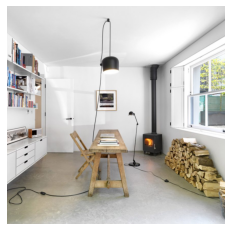

In [10]:
# pick a random image from the dataset
path = df['path'][np.random.randint(0, df.shape[0])]
displayImage(path)

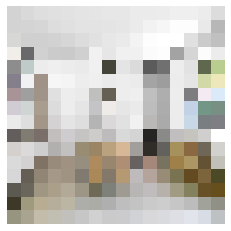

In [11]:
# preprocess the image
image = preprocessImage(path)
displayImage(image)

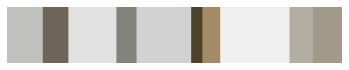

In [12]:
# find color clusters
clt = clusterColors(image)
# find color distribution
hist = centroidHistogram(clt)
# create a color bar
bar = colorBar(hist, clt)

plt.figure()
plt.axis('off')
plt.imshow(bar)
plt.show()

## Scan dataset
Once we know how the algoriths work, let's scan our image dataset and find the color clusters and distribution for each picture. 

The process takes quite a lot of time. In order to be able to stop the process and not loose all the work let's divide the dataset into chunks. Each part will be processed and saved separately. 

If something goes wrong or we want to update the dataset with new data the script will skip the old data and process only new links.

In [ ]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few hours to complete...\n')

# extract the list of filepaths
paths = df['path']

# set chunk size
chunksize = 2000

# iterate through chunks
for n in tq.tqdm(range(int(len(paths)/chunksize)+1)):

  # initialize the containers for colors and distributions values
  colors = []
  distributions = []
  
  # set list slicing start and ending
  start = n * chunksize
  stop = (n+1) * chunksize

  # check if a chunk was already processed and exported
  output = 'files/tmp/df_images-part{}.pkl'.format(n+1)
  if os.path.isfile(output):
    print('{}: file already exists! Continuing...'.format(output))
  
  else:    
    # iterate trough sliced list of filepaths
    for path in tq.tqdm(paths[start:stop]):
      
      # make a sliced copy of the base DataFrame
      df_tmp = df.copy()
      df_tmp = df_tmp.iloc[start:stop]

      try:
        # apply the functions we've just tested
        image = preprocessImage(path)
        clt = clusterColors(image)
        dist = centroidHistogram(clt)
        
        # extract and append colors & distributions values to the containers
        colors.append(clt.cluster_centers_)
        distributions.append(dist)

      # append NaN if error to keep correct shape
      except:
        colors.append(np.nan)
        distributions.append(np.nan)

    # create new columns using the containers
    df_tmp['colours'] = colors
    df_tmp['distribution'] = distributions

    # export a partial DataFrame and print an information
    df_tmp.to_pickle('files/tmp/df_images-part{}.pkl'.format(n+1))
    print('Part {} saved to df_images-part{}.pkl. {} chunks remaining.'.format(n+1, n+1, int((len(paths)/chunksize)-n)))

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few hours to complete...



files/tmp/df_images-part1.pkl: file already exists! Continuing...
files/tmp/df_images-part2.pkl: file already exists! Continuing...
files/tmp/df_images-part3.pkl: file already exists! Continuing...



Part 4 saved to df_images-part4.pkl. 20 chunks remaining.



Part 5 saved to df_images-part5.pkl. 19 chunks remaining.



Part 6 saved to df_images-part6.pkl. 18 chunks remaining.



Part 7 saved to df_images-part7.pkl. 17 chunks remaining.



Part 8 saved to df_images-part8.pkl. 16 chunks remaining.


In [ ]:
dfgh

## Update the DataFrame

In [ ]:
df['colours'] = colours
df['distribution'] = distributions
df

In [ ]:
df = pd.read_pickle('files/images_colours.pkl')
df

## Expand colours column
https://www.iditect.com/how-to/50183625.html

In [ ]:
df.dropna(inplace=True)
df

In [ ]:
dist_columns = ['dist{}'.format(n+1) for n in range(len(df['distribution'][0]))]

df[dist_columns] = pd.DataFrame(df['distribution'].values.tolist(), index=df.index)
df.head()

In [ ]:
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
col6 = []
col7 = []
col8 = []
col9 = []
col10 = []

for colours in df['colours']:
  col1.append(colours[0].tolist())
  col2.append(colours[1].tolist())
  col3.append(colours[2].tolist())
  col4.append(colours[3].tolist())
  col5.append(colours[4].tolist())
  col6.append(colours[5].tolist())
  col7.append(colours[6].tolist())
  col8.append(colours[7].tolist())
  col9.append(colours[8].tolist())
  col10.append(colours[9].tolist())

df['col1'] = col1
df['col2'] = col2
df['col3'] = col3
df['col4'] = col4
df['col5'] = col5
df['col6'] = col6
df['col7'] = col7
df['col8'] = col8
df['col9'] = col9
df['col10'] = col10
df

## DataFrame order

In [ ]:
df = df[::-1]
df.drop_duplicates(subset=['path', 'url'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['colours', 'distribution'], inplace=True)
df

## Export the DataFrame

In [ ]:
# increase the maximum depth of the Python interpreter to avoid an overflow error
sys.setrecursionlimit(10000)

# export
df.to_csv('files/images_colours.csv')